In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

# ✅ Specify the path to your ECG folder in Google Drive
# Example: /content/drive/MyDrive/MIMIC-IV-ECG/diagnostic
DRIVE_ECG_DIR = "/"  # TODO: Replace with your own path
LOCAL_CACHE   = "/"  # Local cache (optional)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the requirements.txt file
!pip install -r requirements.txt

In [ ]:
import os, re, glob, shutil, pathlib
import numpy as np
import wfdb
from tqdm import tqdm
from scipy.signal import butter, iirnotch, filtfilt, resample


def scan_wfdb_bases(root: str, limit: int | None = None):
    """
    Search the Google Drive folder (root) for WFDB records that have both .hea and .dat files,
    returning up to `limit` base paths.
    - Fast traversal using os.scandir, checking for paired .dat files per directory
    - Stops immediately when `limit` is reached
    """
    bases = []
    stack = [root]

    while stack:
        d = stack.pop()
        try:
            with os.scandir(d) as it:
                files = []
                subdirs = []
                for entry in it:
                    if entry.is_dir(follow_symlinks=False):
                        subdirs.append(entry.path)
                    elif entry.is_file():
                        files.append(entry.name)

                file_set = set(files)
                # Check for .hea/.dat pairs in the same directory
                for name in files:
                    if not name.endswith(".hea"):
                        continue
                    dat_name = name[:-4] + ".dat"
                    if dat_name in file_set:
                        base = os.path.join(d, name[:-4])
                        bases.append(base)
                        if limit is not None and len(bases) >= limit:
                            return bases

                # Continue DFS into subdirectories
                stack.extend(subdirs)
        except PermissionError:
            # Skip folders with access restrictions
            continue

    return bases


def load_wfdb_base(local_base: str):
    rec = wfdb.rdrecord(local_base)
    sig = rec.p_signal.T.astype(np.float32)  # (leads, L)
    fs  = float(rec.fs)
    return sig, fs


def _butter_highpass(cut, fs, order=2):
    b, a = butter(order, cut/(fs/2.0), btype='highpass'); return b, a


def _butter_lowpass(cut, fs, order=2):
    b, a = butter(order, cut/(fs/2.0), btype='lowpass');  return b, a


def _apply_filters(x, fs, hp=0.5, lp=50.0, notch_freq=None, q=30.0):
    # x: (leads, L)
    b, a = _butter_highpass(hp, fs, 2); x = filtfilt(b, a, x, axis=-1)
    b, a = _butter_lowpass(lp, fs, 2);  x = filtfilt(b, a, x, axis=-1)
    if notch_freq is not None:
        bN, aN = iirnotch(notch_freq, q, fs); x = filtfilt(bN, aN, x, axis=-1)
    return x


def preprocess_ecg(sig, fs_src, fs_tgt=500, dur_sec=10, notch='auto'):
    """
    ECG preprocessing pipeline:
    (1) Resample → (2) Apply highpass/lowpass/notch filters →
    (3) Cut or pad to 10 seconds → (4) Per-lead z-score normalization
    """
    # Resample
    if fs_src != fs_tgt:
        L_new = int(round(sig.shape[-1] * fs_tgt / fs_src))
        sig = resample(sig, L_new, axis=-1)

    # Apply filters
    notch_freq = None
    if notch == 'auto':
        notch_freq = 50 if fs_tgt % 50 == 0 else (60 if fs_tgt % 60 == 0 else None)
    elif isinstance(notch, (int, float)):
        notch_freq = notch
    sig = _apply_filters(sig, fs_tgt, hp=0.5, lp=50.0, notch_freq=notch_freq)

    # Cut or pad to 10 seconds
    L_need = int(fs_tgt * dur_sec)
    if sig.shape[-1] >= L_need:
        sig = sig[:, :L_need]
    else:
        pad = L_need - sig.shape[-1]
        sig = np.pad(sig, ((0,0),(0,pad)), mode='constant')

    # Z-score normalization per lead
    mu = sig.mean(axis=-1, keepdims=True); sd = sig.std(axis=-1, keepdims=True) + 1e-6
    sig = (sig - mu) / sd
    return sig.astype(np.float32)  # (12, 5000)


def extract_dx_text(local_base: str) -> str:
    hea = local_base + ".hea"
    try:
        with open(hea, "r", encoding="utf-8", errors="ignore") as f:
            txt = f.read()
        m = re.search(r"#\s*Dx\s*:\s*(.*)", txt)
        return m.group(1).strip() if m else ""
    except Exception:
        return ""


def to_cache_path(drive_base: str, drive_root: str, cache_root: str) -> str:
    rel = os.path.relpath(drive_base, drive_root)
    local_base = os.path.join(cache_root, rel)
    pathlib.Path(os.path.dirname(local_base)).mkdir(parents=True, exist_ok=True)
    return local_base


def copy_record_to_cache(drive_base: str, drive_root: str, cache_root: str) -> str:
    """
    Copy the WFDB base pair (.hea/.dat) from Google Drive to LOCAL_CACHE.
    Skips copying if the files already exist locally.
    """
    local_base = to_cache_path(drive_base, drive_root, cache_root)
    for ext in (".hea", ".dat"):
        src = drive_base + ext
        dst = local_base + ext
        if not os.path.exists(dst):
            shutil.copy2(src, dst)
    return local_base


In [ ]:
# Scan for records in the Drive folder
bases = scan_wfdb_bases(DRIVE_ECG_DIR, limit=10)
print(f"Found {len(bases)} records under Drive folder.")

Found 10 records under Drive folder.


In [ ]:
bases

['/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1872/p18727238/s41470097/41470097',
 '/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1872/p18727238/s40976159/40976159',
 '/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1872/p18727238/s40683985/40683985',
 '/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1872/p18727238/s40003533/40003533',
 '/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1872/p18727157/s49583706/49583706',
 '/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-matched-subset-1.0/files/p1872/p18727157/s44014138/44014138',
 '/content/drive/My Drive/Project/MIMIC-IV-ECG/mimic-iv-ecg-diagnostic-electrocardiogram-match

In [ ]:
import os, sys, glob, importlib, numpy as np, torch
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# ===== Path configuration =====
REPO_DIR   = "/ECGFounder"                    # Path to the cloned ECGFounder repository
CKPT_DIR   = os.path.join(REPO_DIR, "checkpoint")     # Folder containing model weights (or specify a direct file path)
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU


In [ ]:
# Add repository path to sys.path so that its modules can be imported
if REPO_DIR not in sys.path:
    sys.path.append(REPO_DIR)

In [ ]:
import wfdb, re
from scipy.signal import butter, iirnotch, filtfilt, resample

def load_wfdb_base(local_base: str):
    rec = wfdb.rdrecord(local_base)
    sig = rec.p_signal.T.astype(np.float32)  # (leads, L)
    fs  = float(rec.fs)
    return sig, fs

def _butter_highpass(cut, fs, order=2):
    b, a = butter(order, cut/(fs/2.0), btype='highpass'); return b, a

def _butter_lowpass(cut, fs, order=2):
    b, a = butter(order, cut/(fs/2.0), btype='lowpass');  return b, a

def _apply_filters(x, fs, hp=0.5, lp=50.0, notch_freq=None, q=30.0):
    # x: (leads, L)
    b, a = _butter_highpass(hp, fs, 2); x = filtfilt(b, a, x, axis=-1)
    b, a = _butter_lowpass(lp, fs, 2);  x = filtfilt(b, a, x, axis=-1)
    if notch_freq is not None:
        bN, aN = iirnotch(notch_freq, q, fs); x = filtfilt(bN, aN, x, axis=-1)
    return x

def preprocess_ecg(sig, fs_src, fs_tgt=500, dur_sec=10, notch='auto'):
    # 1) resample
    if fs_src != fs_tgt:
        L_new = int(round(sig.shape[-1] * fs_tgt / fs_src))
        sig = resample(sig, L_new, axis=-1)
    # 2) filters
    notch_freq = None
    if notch == 'auto':
        notch_freq = 50 if fs_tgt % 50 == 0 else (60 if fs_tgt % 60 == 0 else None)
    elif isinstance(notch, (int, float)):
        notch_freq = notch
    sig = _apply_filters(sig, fs_tgt, hp=0.5, lp=50.0, notch_freq=notch_freq)
    # 3) 10초 cut/pad
    L_need = int(fs_tgt * dur_sec)
    if sig.shape[-1] >= L_need:
        sig = sig[:, :L_need]
    else:
        pad = L_need - sig.shape[-1]
        sig = np.pad(sig, ((0,0),(0,pad)), mode='constant')
    # 4) lead별 z-score
    mu = sig.mean(axis=-1, keepdims=True); sd = sig.std(axis=-1, keepdims=True) + 1e-6
    sig = (sig - mu) / sd
    return sig.astype(np.float32)   # (12, 5000)

def extract_dx_text(local_base: str) -> str:
    hea = local_base + ".hea"
    try:
        with open(hea, "r", encoding="utf-8", errors="ignore") as f:
            txt = f.read()
        m = re.search(r"#\s*Dx\s*:\s*(.*)", txt)
        return m.group(1).strip() if m else ""
    except Exception:
        return ""


In [ ]:
# ============================================================
# ECGFounder checkpoint loader (safe allowlist + automatic structure inference)
#  - _safe_torch_load: try weights_only=True after allowing specific numpy scalar/dtype
#  - On failure, (for trusted checkpoints only) fall back to weights_only=False
#  - build_ecgfounder_from_state_dict: auto-infer Net1D architecture from state_dict
#  - find_checkpoint: automatically pick the most recent weights under ./checkpoint
# ============================================================

import os, re, glob, importlib, torch
from torch.serialization import add_safe_globals

# --- 0) Safe loader: allowlisted numpy objects + try safe mode first ---
def _safe_torch_load(path: str):
    """
    1) First, try weights_only=True with a numpy allowlist
    2) If that fails (and the user trusts the checkpoint), fall back to weights_only=False
    """
    # Numpy class allowlist (for PyTorch 2.4+ weights_only loading)
    try:
        from numpy.core.multiarray import scalar as np_scalar
        import numpy as _np
        add_safe_globals([np_scalar, _np.dtype])
    except Exception:
        pass

    # (1) Attempt safe mode first
    try:
        return torch.load(path, map_location="cpu", weights_only=True)
    except Exception as e_safe:
        print("[_safe_torch_load] weights_only=True failed → falling back to False for trusted ckpt:", e_safe)
        # (2) Only allow the unsafe mode for checkpoints you explicitly trust
        return torch.load(path, map_location="cpu", weights_only=False)

# --- 1) Auto-select a checkpoint file ---
def find_checkpoint(path_like: str):
    if os.path.isdir(path_like):
        cands = glob.glob(os.path.join(path_like, "*.pth")) + \
                glob.glob(os.path.join(path_like, "*.pt"))  + \
                glob.glob(os.path.join(path_like, "*.bin"))
        if not cands:
            raise FileNotFoundError(f"No checkpoint file under: {path_like}")
        return max(cands, key=os.path.getmtime)
    return path_like

# --- 2) Auto-infer stages/channels/kernels from state_dict ---
def _collect_stage_ids(sd):
    st = set()
    pat = re.compile(r"^stage_list\.(\d+)\.")
    for k in sd.keys():
        m = pat.match(k)
        if m:
            st.add(int(m.group(1)))
    return sorted(list(st))

def _count_blocks_in_stage(sd, s):
    # Estimate the number of blocks by counting keys for conv1.weight
    pat = re.compile(fr"^stage_list\.{s}\.block_list\.(\d+)\.conv1\.conv\.weight$")
    ids = set()
    for k in sd.keys():
        m = pat.match(k)
        if m: ids.add(int(m.group(1)))
    return (max(ids)+1) if ids else 1

def build_ecgfounder_from_state_dict(ckpt_path: str, device=None):
    """
    ckpt → parse state_dict → construct an equivalent Net1D(**kwargs) → load weights
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Repository module
    net1d = importlib.import_module("net1d")

    # Load checkpoint (prefer safe path)
    raw = _safe_torch_load(ckpt_path)
    sd = raw.get("state_dict", raw)
    # Strip possible lightning/module prefixes
    sd = {k.replace("model.", "").replace("module.", ""): v for k, v in sd.items()}

    # Required key check
    if "first_conv.conv.weight" not in sd:
        raise RuntimeError("first_conv.conv.weight not found in checkpoint. Unexpected layout.")

    # 1) Infer input/base parameters
    first_w = sd["first_conv.conv.weight"]           # [base_filters, in_channels, kernel_size]
    base_filters = int(first_w.shape[0])
    in_channels  = int(first_w.shape[1])
    kernel_size  = int(first_w.shape[2])

    # Infer groups_width (in_channels of stage0 conv2)
    groups_width = None
    cand_key = "stage_list.0.block_list.0.conv2.conv.weight"
    if cand_key in sd: groups_width = int(sd[cand_key].shape[1])
    if groups_width is None:
        # Looser search
        for k in sd.keys():
            if k.endswith("conv2.conv.weight") and "stage_list.0.block_list.0" in k:
                groups_width = int(sd[k].shape[1]); break
    if groups_width is None:
        groups_width = 16  # Fallback

    # 2) Infer number of stages/filters/blocks
    stages = _collect_stage_ids(sd)
    if not stages:
        stages = [0,1,2,3]  # Fallback
    filter_list   = []
    m_blocks_list = []
    for s in stages:
        # Estimate stage output channels from conv3 out channels (or conv1 out if conv3 not present)
        k3 = f"stage_list.{s}.block_list.0.conv3.conv.weight"
        k1 = f"stage_list.{s}.block_list.0.conv1.conv.weight"
        if k3 in sd:
            out_ch = int(sd[k3].shape[0])
        elif k1 in sd:
            out_ch = int(sd[k1].shape[0])
        else:
            raise RuntimeError(f"Cannot infer out_channels for stage {s}")
        filter_list.append(out_ch)
        m_blocks_list.append(_count_blocks_in_stage(sd, s))

    # 3) Infer number of classes (if dense.weight exists)
    if "dense.weight" in sd:
        n_classes = int(sd["dense.weight"].shape[0])
        print("[ckpt] dense.in_features =", sd["dense.weight"].shape[1])
    else:
        n_classes = 150

    # 4) Build Net1D args (keep typical defaults for stride/ratio, etc.)
    kwargs = dict(
        in_channels=in_channels,
        base_filters=base_filters,
        ratio=1.0,
        filter_list=filter_list,
        m_blocks_list=m_blocks_list,
        kernel_size=kernel_size,
        stride=2,
        groups_width=groups_width,
        n_classes=n_classes,
        use_bn=True,
        use_do=False,
        return_features=False,
        verbose=False,
    )

    print("[deduced] kernel_size  =", kernel_size)
    print("[deduced] in_channels =", in_channels, "| base_filters =", base_filters, "| groups_width =", groups_width)
    print("[deduced] filter_list  =", filter_list)
    print("[deduced] m_blocks_list=", m_blocks_list)
    print("[deduced] n_classes    =", n_classes)

    # 5) Instantiate model and load weights
    model = net1d.Net1D(**kwargs).to(device).eval()
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f"[load_state_dict] missing={len(missing)} unexpected={len(unexpected)}")
    if missing:    print("  missing[:10]   →", [m for m in missing][:10])
    if unexpected: print("  unexpected[:10]→", [u for u in unexpected][:10])

    return model


In [ ]:
CKPT_DIR = "/ECGFounder/checkpoint"  # Or specify a direct checkpoint file path
ckpt_path = find_checkpoint(CKPT_DIR)
model = build_ecgfounder_from_state_dict(ckpt_path)


[_safe_torch_load] weights_only=True 실패 → 신뢰된 ckpt라면 False로 폴백: Weights only load failed. This file can still be loaded, to do so you have two options 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.
[ckpt] dense.in_features = 1024
[deduced] kernel_size  = 16
[deduced] in_channels = 12 | base_filters = 64 | groups_width = 16
[deduced] filte

In [ ]:
@torch.no_grad()
def infer_one_base(base_path: str):
    sig, fs = load_wfdb_base(base_path)
    x = preprocess_ecg(sig, fs_src=fs, fs_tgt=500, dur_sec=10, notch='auto')  # (12, 5000)
    x = torch.from_numpy(x).unsqueeze(0).to(device)                           # (1, 12, L)

    # Try both possible input shapes: (B, C, L) and (B, L, C)
    try:
        logits = model(x)                # (1, num_classes)
    except Exception:
        logits = model(x.transpose(1, 2))  # (1, num_classes)

    logits = logits.detach().cpu().numpy()[0]
    probs  = 1.0 / (1.0 + np.exp(-logits))  # Apply sigmoid for multilabel probabilities
    return probs


In [ ]:
# Reuse the `bases` list created in the previous cell.
# If it doesn’t exist, you can create one as shown below:
# bases = [...]  # A list of 10 base record paths selected by the user

import pandas as pd

results = []
for base in tqdm(bases, desc="ECGFounder inference"):
    try:
        probs = infer_one_base(base)
        # Summarize only the top 10 predictions (replace indices with label names if available)
        top_idx = probs.argsort()[-10:][::-1]
        row = {"record": base, "dx_text": extract_dx_text(base)}
        for rank, idx in enumerate(top_idx, 1):
            row[f"top{rank}_idx"]  = int(idx)
            row[f"top{rank}_prob"] = float(probs[idx])
        results.append(row)
    except Exception as e:
        results.append({"record": base, "error": str(e)})

df = pd.DataFrame(results)
df


ECGFounder inference: 100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


,record,dx_text,top1_idx,top1_prob,top2_idx,top2_prob,top3_idx,top3_prob,top4_idx,top4_prob,...,top6_idx,top6_prob,top7_idx,top7_prob,top8_idx,top8_prob,top9_idx,top9_prob,top10_idx,top10_prob
0,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,3,0.997900,1,0.995668,2,0.985601,13,0.554918,...,14,0.210836,22,0.126353,0,0.091341,27,0.080960,21,0.071348
1,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,3,0.979937,7,0.974503,34,0.903617,1,0.861238,...,2,0.592357,19,0.480471,145,0.475952,14,0.270884,15,0.237360
2,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,0,0.997821,6,0.990948,13,0.982343,14,0.899741,...,21,0.311791,46,0.290005,57,0.173405,42,0.140435,48,0.136738
3,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,3,0.998114,1,0.996321,2,0.993353,34,0.291703,...,22,0.148301,27,0.096236,0,0.082162,21,0.075487,29,0.074266
4,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,0,0.998529,3,0.995678,1,0.991244,14,0.988768,...,21,0.553899,29,0.430550,30,0.360386,15,0.273905,35,0.182090
5,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,0,0.998726,1,0.996942,3,0.995972,14,0.982545,...,29,0.294442,22,0.196931,26,0.183300,27,0.176895,30,0.158186
6,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,13,0.994826,0,0.990017,6,0.983388,25,0.854399,...,35,0.463289,10,0.421120,21,0.342071,22,0.207041,42,0.192070
7,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,0,0.999057,13,0.991983,6,0.986950,14,0.896122,...,21,0.447877,12,0.198286,48,0.185587,40,0.166623,3,0.151583
8,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,3,0.938897,0,0.897225,75,0.810259,84,0.747108,...,52,0.502767,13,0.252455,24,0.248837,9,0.126851,20,0.113254
9,/content/drive/My Drive/Project/MIMIC-IV-ECG/m...,,3,0.969960,0,0.968397,24,0.824566,1,0.739704,...,13,0.668023,84,0.645354,52,0.588052,15,0.310901,54,0.270430


In [ ]:
import os, numpy as np

TASK_PATH = "/ECGFounder/tasks.txt"  # Modify this path if needed

def read_task_labels(task_path, n_classes=None):
    if not os.path.isfile(task_path):
        raise FileNotFoundError(f"task.txt not found: {task_path}")
    with open(task_path, "r", encoding="utf-8", errors="ignore") as f:
        # Remove empty lines and surrounding whitespace
        labels = [ln.strip() for ln in f if ln.strip()]

    # Format labels for readability (uppercase and replace underscores with spaces)
    labels = [lbl.replace("_", " ").upper() for lbl in labels]

    # Automatically infer model output dimension (based on length of probs)
    if n_classes is None:
        try:
            _probs = infer_one_base(bases[0])  # Reuse the function defined earlier
            n_classes = len(_probs)
        except Exception:
            n_classes = len(labels)

    # Adjust label list length: trim if too long, pad with placeholders if too short
    if len(labels) > n_classes:
        labels = labels[:n_classes]
    elif len(labels) < n_classes:
        labels += [f"LABEL_{i}" for i in range(len(labels), n_classes)]

    print(f"[task.txt] Loaded {len(labels)} labels (model classes={n_classes})")
    print(" Sample:", labels[:5])
    return labels

label_names = read_task_labels(TASK_PATH)


[task.txt] loaded 150 labels (model classes=150)
 sample: ['ABNORMAL ECG', 'NORMAL SINUS RHYTHM', 'NORMAL ECG', 'SINUS RHYTHM', 'SINUS BRADYCARDIA']


In [ ]:
import pandas as pd

def predict_with_names(base_path, topk=10):
    probs = infer_one_base(base_path)
    idxs  = probs.argsort()[-topk:][::-1]
    names = [label_names[i] if i < len(label_names) else f"LABEL_{i}" for i in idxs]
    rows = [{"rank": r+1, "idx": int(i), "name": names[r], "prob": float(probs[i])}
            for r, i in enumerate(idxs)]
    return pd.DataFrame(rows)

# Example: first sample
display(predict_with_names(bases[0], topk=8))


,rank,idx,name,prob
0,1,3,SINUS RHYTHM,0.997900
1,2,1,NORMAL SINUS RHYTHM,0.995668
2,3,2,NORMAL ECG,0.985601
3,4,13,LEFT ATRIAL ENLARGEMENT,0.554918
4,5,10,BORDERLINE ECG,0.494315
5,6,14,NONSPECIFIC T WAVE ABNORMALITY,0.210836
6,7,22,NONSPECIFIC T WAVE ABNORMALITY NO LONGER EVIDE...,0.126353
7,8,0,ABNORMAL ECG,0.091341


In [ ]:
import os, numpy as np

TASKS_PATH = "/ECGFounder/tasks.txt"  # ← Make sure this path is correct

def read_tasks_labels(tasks_path, n_classes=None):
    if not os.path.isfile(tasks_path):
        raise FileNotFoundError(f"tasks.txt not found: {tasks_path}")
    with open(tasks_path, "r", encoding="utf-8", errors="ignore") as f:
        labels = [ln.strip() for ln in f if ln.strip()]

    # Clean up label text for readability (adjust if needed)
    labels = [lbl.replace("_", " ").upper() for lbl in labels]

    # Automatically determine the number of model output classes
    if n_classes is None:
        try:
            n_classes = len(infer_one_base(bases[0]))
        except Exception:
            n_classes = len(labels)

    # Adjust the label list length
    if len(labels) > n_classes:
        labels = labels[:n_classes]
    elif len(labels) < n_classes:
        labels += [f"LABEL_{i}" for i in range(len(labels), n_classes)]

    print(f"[tasks.txt] {len(labels)} labels loaded (model classes={n_classes})")
    return labels

label_names = read_tasks_labels(TASKS_PATH)


[tasks.txt] 150 labels loaded (model classes=150)


In [ ]:
import re, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, wfdb

def extract_dx_text(local_base: str) -> str:
    hea = local_base + ".hea"
    try:
        with open(hea, "r", encoding="utf-8", errors="ignore") as f:
            txt = f.read()
        m = re.search(r"#\s*Dx\s*:\s*(.*)", txt)
        return m.group(1).strip() if m else ""
    except Exception:
        return ""

def predict_with_names(base_path, topk=8):
    probs = infer_one_base(base_path)
    idxs  = probs.argsort()[-topk:][::-1]
    rows  = []
    for r, i in enumerate(idxs, 1):
        name = label_names[i] if i < len(label_names) else f"LABEL_{i}"
        rows.append({"rank": r, "idx": int(i), "name": name, "prob": float(probs[i])})
    return pd.DataFrame(rows)

def _reorder_to_standard(lead_names):
    """Reorder indices to the standard order (I, II, III, aVR, aVL, aVF, V1–V6). Skips missing leads."""
    std = ["I","II","III","AVR","AVL","AVF","V1","V2","V3","V4","V5","V6"]
    # Normalize input names by uppercasing and removing spaces
    norm = [ln.upper().replace(" ","") for ln in lead_names]
    idx = []
    for name in std:
        key = name.upper().replace(" ","")
        if key in norm:
            idx.append(norm.index(key))
    # Append any remaining (non-standard) leads at the end
    rest = [i for i in range(len(lead_names)) if i not in idx]
    return idx + rest

def _draw_ecg_paper(ax, t_max, y_min, y_max,
                    small_time=0.04, big_time=0.20,
                    small_amp=0.2, big_amp=1.0,
                    color_minor="#ffd6d6", color_major="#ff7a7a", alpha_minor=0.6, alpha_major=0.9):
    """ECG paper grid (horizontal=time, vertical=amplitude).
       small_time=0.04s (minor grid), big_time=0.20s (major grid).
       small_amp/big_amp are in data units (z-score in this script)."""
    ax.set_facecolor("#fff5f5")  # Light pink background
    # Vertical lines (time)
    v_minor = np.arange(0, t_max + 1e-6, small_time)
    for x in v_minor:
        ax.axvline(x, color=color_minor, lw=0.6, alpha=alpha_minor, zorder=0)
    v_major = np.arange(0, t_max + 1e-6, big_time)
    for x in v_major:
        ax.axvline(x, color=color_major, lw=0.9, alpha=alpha_major, zorder=0)
    # Horizontal lines (amplitude)
    a_minor = np.arange(math.floor(y_min/small_amp)*small_amp, y_max + small_amp, small_amp)
    for y in a_minor:
        ax.axhline(y, color=color_minor, lw=0.6, alpha=alpha_minor, zorder=0)
    a_major = np.arange(math.floor(y_min/big_amp)*big_amp, y_max + big_amp, big_amp)
    for y in a_major:
        ax.axhline(y, color=color_major, lw=0.9, alpha=alpha_major, zorder=0)

def plot_ecg_paper(base_path, show_preprocessed=False,
                   fs_target=500, duration_sec=10, topk=8,
                   figsize=(20, 12), dpi=110):
    # 1) Load WFDB record
    rec = wfdb.rdrecord(base_path)
    lead_names = getattr(rec, "sig_name", [f"lead_{i}" for i in range(rec.n_sig)])
    sig_raw = rec.p_signal.T.astype(np.float32)  # (leads, L_raw)
    fs = float(rec.fs)

    # 2) Take a 10-second segment
    L_need = int(fs * duration_sec)
    if sig_raw.shape[1] >= L_need:
        sig_show = sig_raw[:, :L_need]
    else:
        pad = L_need - sig_raw.shape[1]
        sig_show = np.pad(sig_raw, ((0,0),(0,pad)), mode="constant")
    t = np.arange(sig_show.shape[1]) / fs  # seconds

    # 3) Reorder leads into the standard sequence
    order = _reorder_to_standard(lead_names)
    sig_show = sig_show[order]
    lead_names = [lead_names[i] for i in order]
    n_leads = sig_show.shape[0]

    # 4) Optional: preprocessed signal
    sig_proc = None
    if show_preprocessed:
        sig_proc = preprocess_ecg(rec.p_signal.T.astype(np.float32), fs_src=fs, fs_tgt=fs_target, dur_sec=duration_sec)
        sig_proc = sig_proc[order]
        tp = np.arange(sig_proc.shape[1]) / fs_target

    # 5) Prediction summary
    try:
        probs = infer_one_base(base_path)
        idxs  = probs.argsort()[-topk:][::-1]
        names = [label_names[i] if i < len(label_names) else f"LABEL_{i}" for i in idxs]
        top_text = " | ".join([f"{r+1}. {names[r]} ({probs[idxs[r]]:.3f})" for r in range(len(idxs))])
    except Exception as e:
        top_text = f"(prediction failed: {e})"
    dx_text = extract_dx_text(base_path)

    # 6) Layout (3×4) with a wide figure for readability
    cols = 4; rows = math.ceil(n_leads / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, dpi=dpi, sharex=True)
    axes = axes.ravel()

    # Per-lead y-range: ±margin based on 99th percentile (z-score units)
    # (The raw signal isn’t in mV; the grid is styled for appearance only.)
    for i in range(n_leads):
        ax = axes[i]
        y = sig_show[i]
        y_abs = np.abs(y)
        y_lim = float(np.percentile(y_abs, 99)) + 0.2
        y_min, y_max = -y_lim, y_lim

        _draw_ecg_paper(ax, t_max=t[-1], y_min=y_min, y_max=y_max,
                        small_time=0.04, big_time=0.20,  # Grid spacing assuming 25 mm/s (for appearance)
                        small_amp=0.2, big_amp=1.0)      # z-score units (for appearance)

        ax.plot(t, y, color="k", lw=1.0)
        if sig_proc is not None:
            ax.plot(tp, sig_proc[i], color="tab:blue", lw=0.6, alpha=0.6)

        ax.set_ylim(y_min, y_max)
        ax.set_ylabel(lead_names[i], rotation=0, labelpad=22, va='center', fontsize=10)

        # Minimize tick labels
        if i < (rows-1)*cols:
            ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Remove empty panels
    for j in range(n_leads, rows*cols):
        fig.delaxes(axes[j])

    title = os.path.basename(base_path)
    if dx_text:  title += f"\nDx: {dx_text}"
    if top_text: title += f"\nPred(top-{topk}): {top_text}"
    fig.suptitle(title, fontsize=13, y=0.98)
    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

    # Also show a prediction table
    try:
        display(predict_with_names(base_path, topk=topk))
    except Exception as e:
        print("prediction table failed:", e)


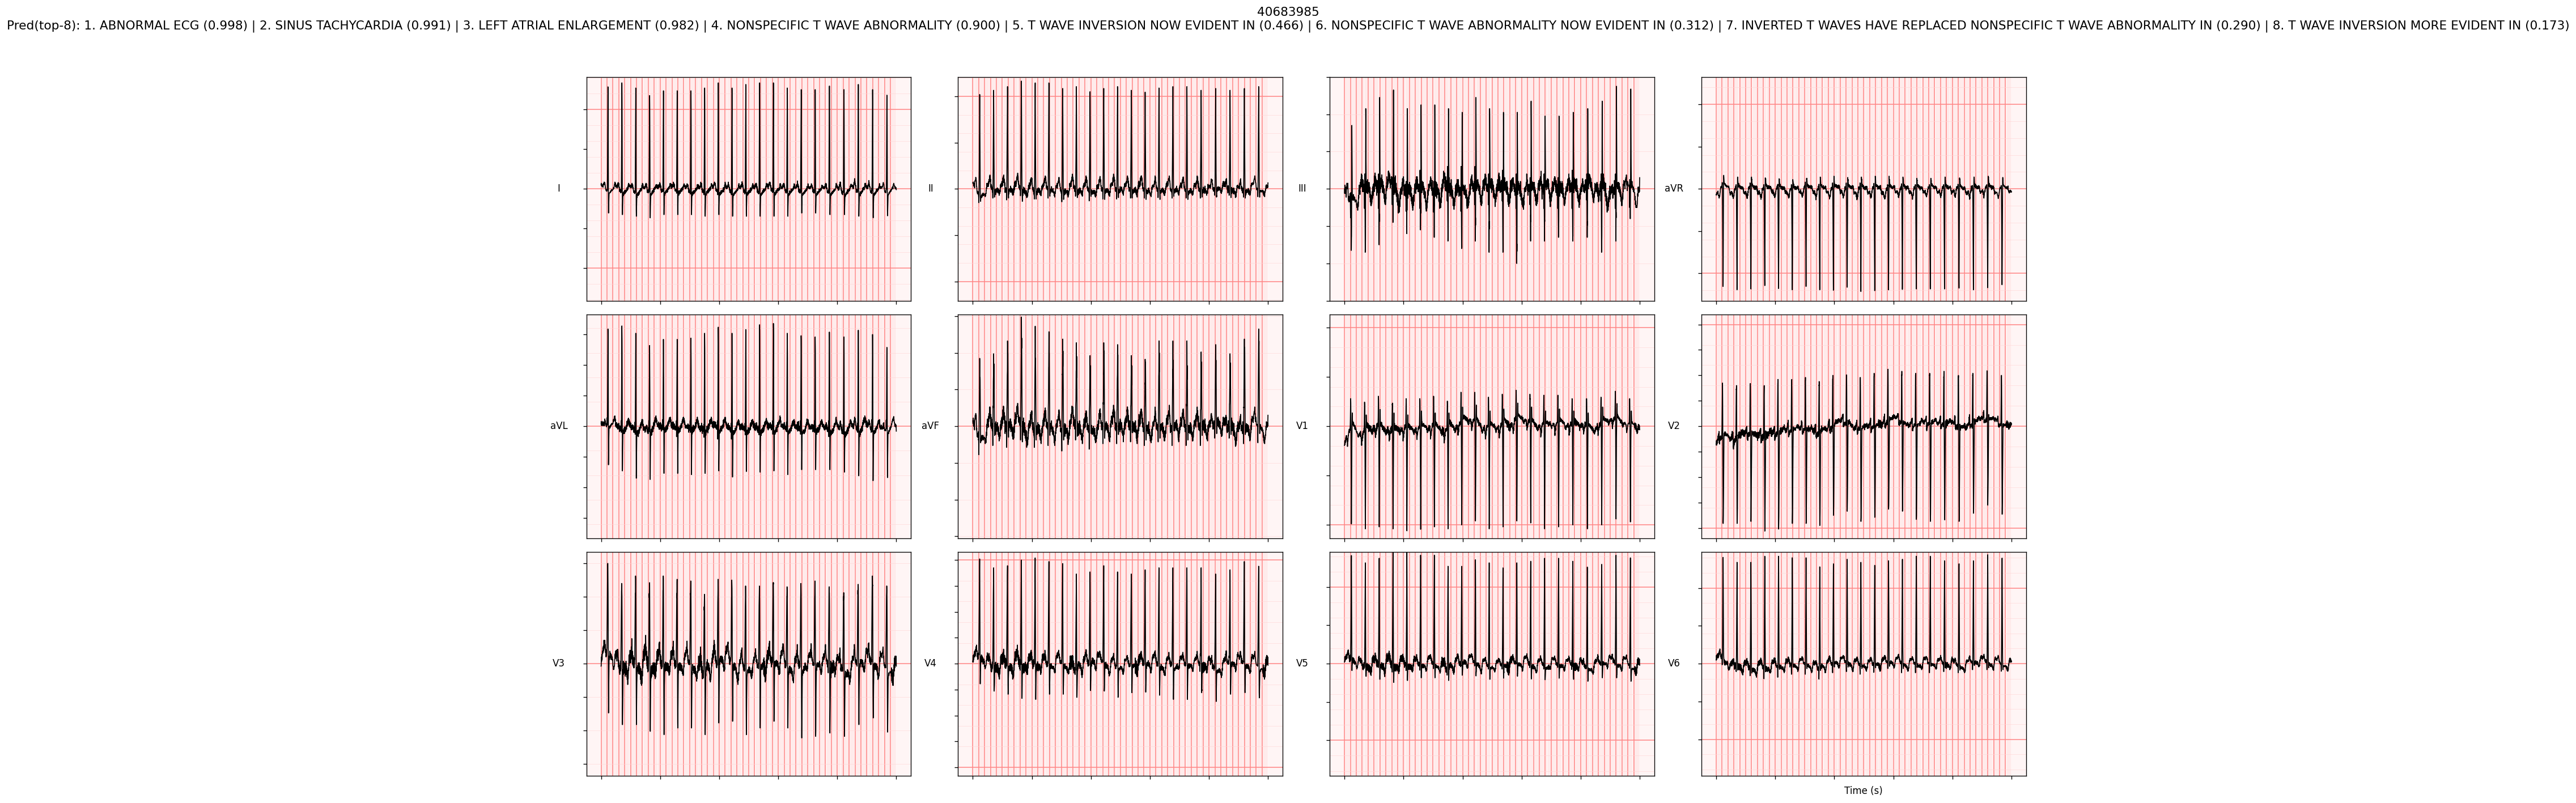

,rank,idx,name,prob
0,1,0,ABNORMAL ECG,0.997821
1,2,6,SINUS TACHYCARDIA,0.990948
2,3,13,LEFT ATRIAL ENLARGEMENT,0.982343
3,4,14,NONSPECIFIC T WAVE ABNORMALITY,0.899741
4,5,23,T WAVE INVERSION NOW EVIDENT IN,0.466074
5,6,21,NONSPECIFIC T WAVE ABNORMALITY NOW EVIDENT IN,0.311791
6,7,46,INVERTED T WAVES HAVE REPLACED NONSPECIFIC T W...,0.290005
7,8,57,T WAVE INVERSION MORE EVIDENT IN,0.173405


In [ ]:
# Check one example
plot_ecg_paper(bases[2], show_preprocessed=False, topk=8, figsize=(22, 12), dpi=120)

# Run on another record if needed
# plot_ecg_paper(bases[1], show_preprocessed=True, topk=8, figsize=(22, 12))


In [ ]:
# ── Helper utilities to extract penultimate (pre-classifier) embeddings ────────
import torch, numpy as np
import torch.nn as nn

def _find_last_linear_module(model: nn.Module):
    """
    Find the last nn.Linear module inside the model.
    Priority order: dense, fc, classifier, head → otherwise return the last Linear found by traversal.
    """
    # 1) Check common attribute names first
    for name in ["dense", "fc", "classifier", "head"]:
        if hasattr(model, name) and isinstance(getattr(model, name), nn.Linear):
            return name, getattr(model, name)

    # 2) Fallback: traverse all modules and return the last Linear
    last_name, last_mod = None, None
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            last_name, last_mod = n, m
    if last_mod is None:
        raise RuntimeError("No nn.Linear module found in model.")
    return last_name, last_mod

class PenultimateHook:
    """
    Forward hook that captures the input tensor to the classifier (Linear) layer.
    - For a forward hook, inputs[0] is the feature vector fed into that Linear: shape (B, D).
    """
    def __init__(self, model: nn.Module):
        self.model = model
        self.handle = None
        self.tensor = None
        self.layer_name, self.layer = _find_last_linear_module(model)

        def hook(module, inputs, output):
            # inputs is a tuple; we want inputs[0] with shape (B, D)
            self.tensor = inputs[0].detach()

        self.handle = self.layer.register_forward_hook(hook)

    def clear(self):
        self.tensor = None

    def close(self):
        if self.handle is not None:
            self.handle.remove()
            self.handle = None

def extract_embedding_from_tensor(x_tensor: torch.Tensor, model: nn.Module, device=None):
    """
    x_tensor: (1, 12, L) or (1, L, 12)
    Returns: (embedding: np.ndarray [D], logits: np.ndarray [C])
    """
    device = device or next(model.parameters()).device
    hook = PenultimateHook(model)
    try:
        with torch.no_grad():
            # Support both (B, C, L) and (B, L, C) input conventions
            try:
                logits = model(x_tensor.to(device))
            except Exception:
                logits = model(x_tensor.transpose(1, 2).to(device))

        # Normalize outputs
        if isinstance(logits, (tuple, list)):
            logits = logits[0]
        logits = logits.detach().cpu().numpy().squeeze()

        if hook.tensor is None:
            raise RuntimeError("Penultimate tensor was not captured. Check hook layer selection.")
        emb = hook.tensor.detach().cpu().numpy().squeeze()
        return emb, logits
    finally:
        hook.close()


In [ ]:
def extract_embedding_one_base(base_path, fs_tgt=500, dur_sec=10):
    """
    base_path (WFDB base, without extension) → (embedding[D], logits[C])
    """
    sig, fs = load_wfdb_base(base_path)
    x = preprocess_ecg(sig, fs_src=fs, fs_tgt=fs_tgt, dur_sec=dur_sec)  # (12, 5000)
    x = torch.from_numpy(x).unsqueeze(0)  # (1, 12, L)
    emb, logits = extract_embedding_from_tensor(x, model)
    return emb, logits

# Example: first sample
emb0, logits0 = extract_embedding_one_base(bases[0])
print("embedding shape:", emb0.shape, "| logits shape:", logits0.shape)



embedding shape: (1024,) | logits shape: (150,)


In [ ]:
emb0

array([ 3.2867116e-01,  3.5003950e-03,  4.0416774e-01, ...,
        2.5006052e-02,  1.9933153e-05, -3.7710794e-04],
      shape=(1024,), dtype=float32)